# Análisis y Reporte sobre el desempeño del modelo

Se eligió hacer el análisis con el modelo implementado mediante con el uso de frameworks, en esta ocasión Scikit-Learn, utilizando un random forest classifier y el conjunto de datos de la misma librería llamado Iris. A continuación se muestra no solo la implementación del mismo sino también el análisis correspondiente de los resultados obtenidos desde la identificación e interpretación del bias y varianza, así como también el cuidado realizado para evitar underfitting y overfitting del modelo, por lo cual también se dividió el conjunto de datos en train, validation y test.

In [1]:
%pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from mlxtend.evaluate import bias_variance_decomp
from sklearn.datasets import fetch_openml

In [3]:
# Cargar datos
iris = datasets.load_iris()
# mnist = fetch_openml('mnist_784', version=1, as_frame = False)

In [4]:
# Creación y separación de datos
X = pd.DataFrame(iris['data'], columns = iris['feature_names'])
y = pd.DataFrame(iris['target'], columns = ['species'])


## Implementación del modelo


Se se para el conjunto de datos en sets de entrenamiento, validación y prueba.
En este caso la proporción es la siguiente:
- Entrenamiento: 80%
- Validación: 10%
- Prueba: 80%

In [36]:
# Separación del conjunto de datos para entrenamiento, validación y prueba
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.5)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
y_train, y_valid, y_test = y_train["species"], y_valid["species"],  y_test["species"]

En este caso la clasificación es mediante un random forest classifier

In [37]:
# Creación del modelo
clf = RandomForestClassifier(n_estimators = 100)

In [38]:
# Entrenamiento de datos
clf.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
# Predicción
Y_hat = clf.predict(X_valid)

## Resultado del modelo previo al ajuste de hiperparámetros

In [41]:
# Resultados del modelo
result = y_valid.copy()
result = pd.DataFrame(result)
result['y_hat'] = Y_hat.copy()
print("Comparación valores esperados vs valores predichos:\n", result[:10])
print('\n Accuracy: ', accuracy_score(y_valid, Y_hat))

Comparación valores esperados vs valores predichos:
      species  y_hat
53         1      1
107        2      2
108        2      2
28         0      0
103        2      2
104        2      2
102        2      2
137        2      2
46         0      0
58         1      1

 Accuracy:  0.972972972972973


In [10]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf, X_train.values, y_train.values, X_valid.values, y_valid.values, loss='0-1_loss', random_seed = 42)

In [11]:
print(f"Average bias {avg_bias}")
print(f"Average variance {avg_var}")

Average bias 0.0
Average variance 0.005833333333333333


**Accuracy**

Podemos observar un alto accuracy del modelo lo cual aunque es un buen indicador de lo bueno que es el modelo en la clasificación.

**Bias y variance**

Debido a que el sesgo o bias no es alto al igual que la varianza, se puede concluir que el modelo aparentemente no tiene overfitting ni underfitting.





## Ajuste de hiperparámetros

Para encontrar los mejores hiperparámetros del modelo, n_estimators y max_depth en este caso se decidió usar GridSearchCV, el cual ya tiene integrado Cross-validation lo que ayuda aun más al modelo a que este no se sobreajuste a los dato.

Aunque se debió utilizar el set de validación, debido a que el conjunto de datos es muy pequeño (150 observaciones), hacerlo de ese modo resulta en accuracy de 1, lo cual no representa 

In [12]:
param_grid = {
     'n_estimators': [100, 200, 400],
     'max_depth':[10, 20, 30, None]
}

In [13]:
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier()
grid_clf = GridSearchCV(classifier, param_grid, cv=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30, None],
                         'n_estimators': [100, 200, 400]})

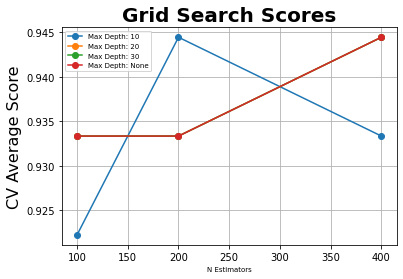

In [14]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=7)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=7)
    ax.grid('on')

# Calling Method
plot_grid_search(grid_clf.cv_results_, param_grid["n_estimators"], param_grid["max_depth"], 'N Estimators', 'Max Depth')

In [15]:
grid_clf.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=200)

## Resultados del modelo con el conjunto de pruebas

In [16]:
# Resultados del modelo
Y_hat = grid_clf.best_estimator_.predict(X_test)
result = y_test.copy()
result = pd.DataFrame(result)
result['y_hat'] = Y_hat.copy()
print("Comparación valores esperados vs valores predichos:\n", result[:10])
print('\n Accuracy: ', accuracy_score(y_test, Y_hat))

Comparación valores esperados vs valores predichos:
      species  y_hat
48         0      0
53         1      1
92         1      1
14         0      0
110        2      2
98         1      1
57         1      1
107        2      2
59         1      1
120        2      2

 Accuracy:  0.9666666666666667


In [17]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(grid_clf.best_estimator_, X_train.values, y_train.values, X_test.values, y_test.values, loss='0-1_loss', random_seed = 42)

In [18]:
print(f"Average bias {avg_bias}")
print(f"Average variance {avg_var}")

Average bias 0.03333333333333333
Average variance 0.0028333333333333335


Debido a que los resultados son muy parecidos a los del modelo antes del ajuste de hiperparámetros el análisis de los resultados se mantiene.

**Accuracy**

Podemos observar un alto accuracy del modelo lo cual aunque es un buen indicador de lo bueno que es el modelo en la clasificación.

**Bias y variance**

Debido a que el sesgo o bias no es alto al igual que la varianza, se puede concluir que el modelo aparentemente no tiene overfitting ni underfitting.